In [0]:
import pickle
import numpy as np
import pandas as pd

%matplotlib inline
%matplotlib inline
from importlib import reload
# import utils; reload(utils)
# from utils import *
#from python_utils import *

from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from numpy import moveaxis # used to change from channel first to channel last
from numpy import asarray
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU hurray 12/1/19  yes at: {}'.format(device_name))
import time
import numpy as np

Found GPU hurray 12/1/19  yes at: /device:GPU:0


In [0]:
import keras

Using TensorFlow backend.


In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
from google.colab import drive
drive.mount('/gdrive')
% cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
# Loading the data

#import pickle
#drive.mount('/My Drive')
DATA_PATH = "/gdrive/My Drive/ML_project/data5.pickle"  # for gray image data 5
#infile = open(DATA_PATH+'/data0.pickle','rb')  # this is for rgb images
infile = open(DATA_PATH+'/data5.pickle','rb')  # this is for grayscale images
traffic_data = pickle.load(infile)
print('loaded the data')
#with open('data5.pickle', 'rb') as pickle_sign:
#    traffic_data = pickle.load(pickle_sign)
    

loaded the data


In [0]:
traffic_data.keys()

dict_keys(['x_test', 'y_test', 'x_train', 'y_train', 'x_validation', 'y_validation', 'labels'])

In [0]:
 # Assigning variables as well converting converting the model shape from NCHW to NHWC
x_train = traffic_data['x_train']
x_train = moveaxis(x_train, 1, 3)
y_train = traffic_data['y_train']
x_val = traffic_data['x_validation']
x_val = moveaxis(x_val, 1, 3)
y_val = traffic_data['y_validation']
x_test = traffic_data['x_test']
x_test = moveaxis(x_test, 1, 3)
y_test = traffic_data['y_test']
labels = traffic_data['labels']
print('hey x_train',x_train.shape)
print('y_train',y_train.shape)
print('x_test',x_test.shape)
print('y_test',y_test.shape)
print('x_val',x_val.shape)
print('y_val is ',y_val.shape)





hey x_train (86989, 32, 32, 1)
y_train (86989,)
x_test (12630, 32, 32, 1)
y_test (12630,)
x_val (4410, 32, 32, 1)
y_val is  (4410,)


In [0]:
file = r'/gdrive/My Drive/ML_project/label_names.csv'
traffic_signs = pd.read_csv(file)
traffic_signs.head(n=5)


,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [0]:
# To get the count of unique classes in the dataset
n_classes = len(set(y_train))
print("the number of classes",n_classes)

the number of classes 43


In [0]:
def group_img_id_to_lbl(lbs_ids, lbs_names):    
    """
    Utility function to group images by label 
    """
    arr_map = []
    for i in range(0, lbs_ids.shape[0]):
        label_id = lbs_ids[i]
        label_name = lbs_names[lbs_names["ClassId"] == label_id]["SignName"].values[0]
        arr_map.append({"img_id": i, "label_id": label_id, "label_name": label_name})

    return pd.DataFrame(arr_map)

In [0]:
X_train_id_to_label = group_img_id_to_lbl(y_train, traffic_signs)
X_train_id_to_label.head(n=3)

,img_id,label_id,label_name
0,0,37,Go straight or left
1,1,27,Pedestrians
2,2,38,Keep right


In [0]:
(X_train_id_to_label["label_id"])[0]

37

In [0]:
def group_img_id_to_lb_count(img_id_to_lb):
    """
    Returns a pivot table table indexed by label id and label name, where the aggregate function is count
    """
    return pd.pivot_table(img_id_to_lb, index=["label_id", "label_name"], values=["img_id"], aggfunc='count')

In [0]:
X_train_group_by_label_count = group_img_id_to_lb_count(X_train_id_to_label)
X_train_group_by_label_count.head(n=3)

,,img_id
label_id,label_name,
0,Speed limit (20km/h),2023
1,Speed limit (30km/h),2023
2,Speed limit (50km/h),2023


In [0]:
def group_img_id_to_lbl(lbs_ids, lbs_names):    
    """
    Utility function to group images by label 
    """
    arr_map = []
    for i in range(0, lbs_ids.shape[0]):
        label_id = lbs_ids[i]
        label_name = lbs_names[lbs_names["ClassId"] == label_id]["SignName"].values[0]
        arr_map.append({"img_id": i, "label_id": label_id, "label_name": label_name})

    return pd.DataFrame(arr_map)

def group_img_id_to_lb_count(img_id_to_lb):
    """
    Returns a pivot table table indexed by label id and label name, where the aggregate function is count
    """
    return pd.pivot_table(img_id_to_lb, index=["label_id", "label_name"], values=["img_id"], aggfunc='count')

def create_sample_set(grouped_imgs_by_label, imgs, labels, pct=0.4):
    """
    Creates a sample set containing pct elements of the original grouped dataset
    """
    X_sample = []
    y_sample = []

    for (lid, lbl), group in grouped_imgs_by_label:
        group_size = group['img_id'].size
        img_count_to_copy = int(group_size * pct)
        rand_idx = np.random.randint(0, high=group_size, size=img_count_to_copy, dtype='int')

        selected_img_ids = group.iloc[rand_idx]['img_id'].values
        selected_imgs = imgs[selected_img_ids]
        selected_labels = labels[selected_img_ids]
        X_sample = selected_imgs if len(X_sample) == 0 else np.concatenate((selected_imgs, X_sample), axis=0)
        y_sample = selected_labels if len(y_sample) == 0 else np.concatenate((selected_labels, y_sample), axis=0)


    return (X_sample, y_sample)

In [0]:

X_train_id_to_label = group_img_id_to_lbl(y_train, traffic_signs)

In [0]:
X_train_id_to_label.keys()


Index(['img_id', 'label_id', 'label_name'], dtype='object')

In [0]:
def group_img_id_to_lb_count(img_id_to_lb):
    """
    Returns a pivot table table indexed by label id and label name, where the aggregate function is count
    """
    return pd.pivot_table(img_id_to_lb, index=["label_id", "label_name"], values=["img_id"], aggfunc='count')

In [0]:
X_train_group_by_label_count = group_img_id_to_lb_count(X_train_id_to_label)
X_train_group_by_label_count.head(n=5)

,,img_id
label_id,label_name,
0,Speed limit (20km/h),2023
1,Speed limit (30km/h),2023
2,Speed limit (50km/h),2023
3,Speed limit (60km/h),2023
4,Speed limit (70km/h),2023


In [0]:


def show_image_list(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):
    """
    Utility function to show us a list of traffic sign images
    """
    img_count = len(img_list)
    rows = img_count // cols
    cmap = None

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    
    for i in range(0, img_count):
        img_name = img_labels[i]     
        img = img_list[i]
        if len(img.shape) < 3 or img.shape[-1] < 3:
            cmap = "gray"
            img = np.reshape(img, (img.shape[0], img.shape[1]))
        
        if not show_ticks:            
            axes[i].axis("off")
            
        axes[i].imshow(img, cmap=cmap)
    
    fig.suptitle(title, fontsize=12, fontweight='bold', y = 0.6)
    fig.tight_layout()
    plt.show()
    
    return


In [0]:
def show_random_dataset_images(group_label, imgs, to_show=5):
    """
    This function takes a DataFrame of items group by labels as well as a set of images and randomly selects to_show images to display
    """
    for (lid, lbl), group in group_label:
        # print("[{0}] : {1}".format(lid, lbl))
        rand_idx = np.random.randint(0, high=group['img_id'].size, size=to_show, dtype='int')
        selected_rows = group.iloc[rand_idx]

        selected_img = list(map(lambda img_id: imgs[img_id], selected_rows['img_id']))
        selected_labels = list(map(lambda label_id: label_id, selected_rows['label_id']))
        show_image_list(selected_img, selected_labels, "{0}: {1}".format(lid, lbl), cols=to_show, fig_size=(7, 7), show_ticks=False)

In [0]:
# a = X_train_id_to_label['img_id'].size
# rand_idx = np.random.randint(0, a, 5, dtype='int')
# rand_idx

In [0]:
# b = X_train_id_to_label 
# selected_rows = b.iloc[rand_idx]
# selected_img = list(map(lambda img_id: traffic_data['x_train'][img_id], selected_rows['img_id']))
# selected_labels = list(map(lambda label_id: label_id, selected_rows['label_id']))

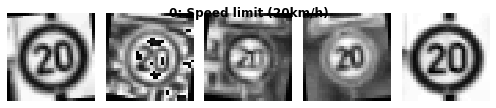

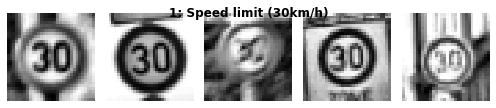

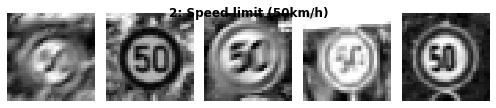

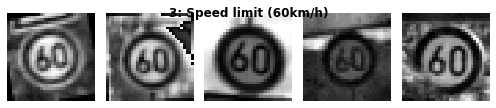

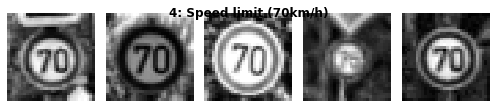

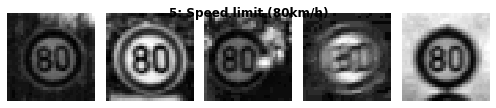

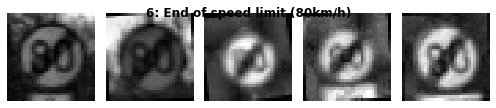

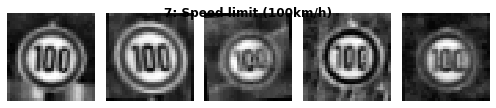

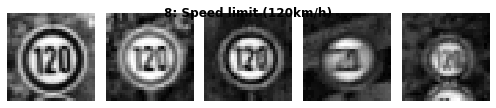

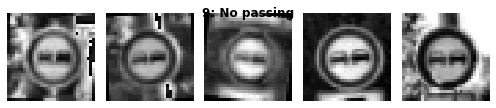

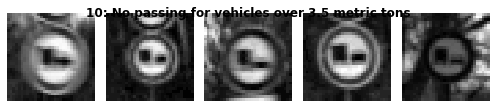

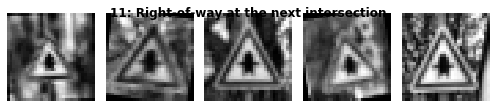

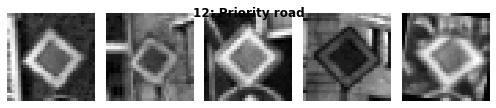

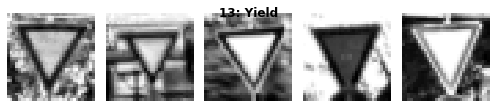

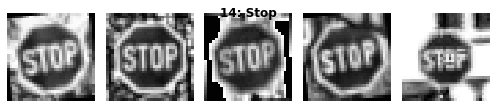

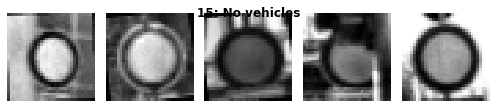

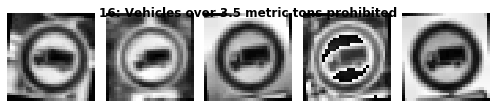

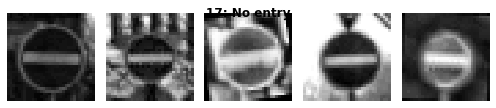

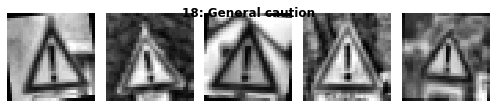

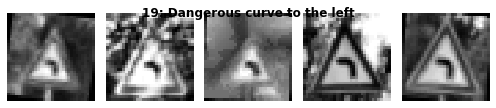

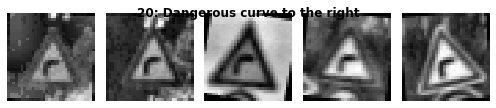

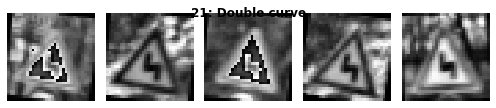

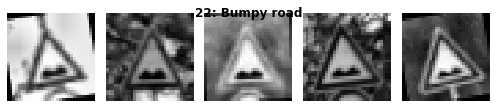

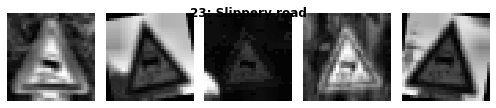

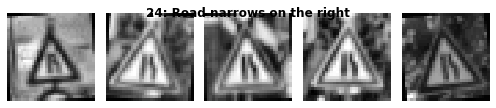

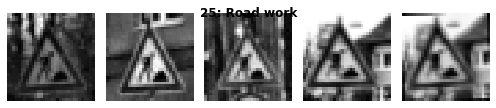

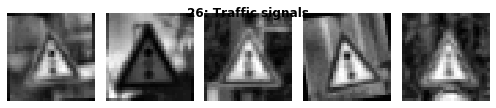

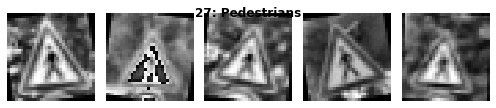

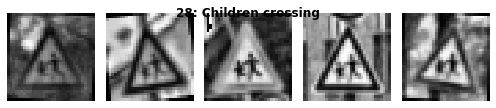

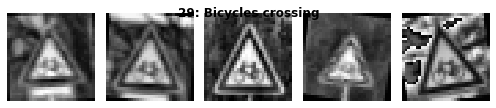

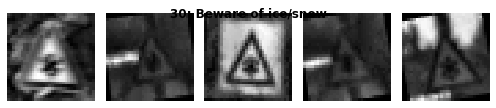

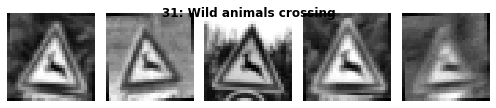

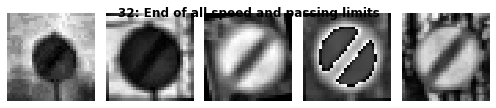

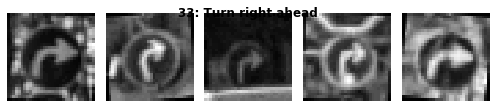

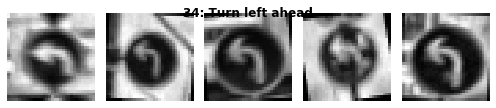

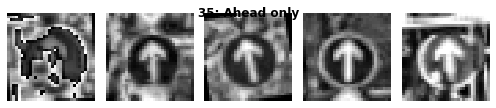

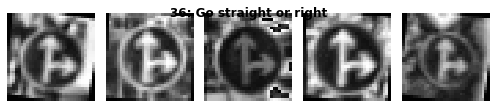

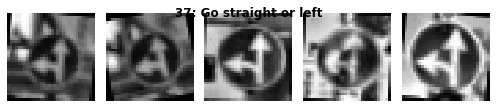

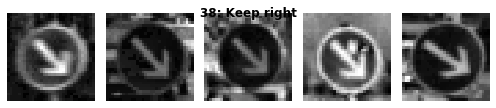

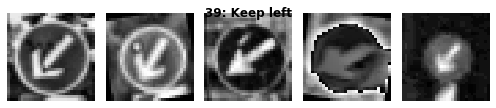

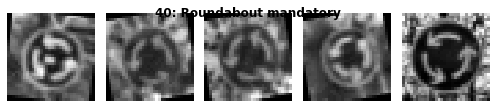

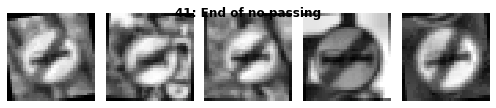

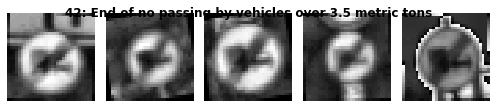

they are gray scale 


In [0]:
# Showing 5 images from each classes
X_train_group_by_label = X_train_id_to_label.groupby(["label_id", "label_name"])
img_per_class = 3

show_random_dataset_images(X_train_group_by_label, x_train)
print('they are gray scale ')

Groups images in validation set 

In [0]:

# Create a data frame whereby we index image id  with label
X_valid_id_to_label = group_img_id_to_lbl(y_val, traffic_signs)


# Let's print a few of those mappings now
X_valid_id_to_label.head(n=3)

,img_id,label_id,label_name
0,0,9,No passing
1,1,37,Go straight or left
2,2,31,Wild animals crossing


In [0]:
# We should group by label id to understand the distribution
X_valid_group_by_label_count = group_img_id_to_lb_count(X_valid_id_to_label)
X_valid_group_by_label_count.head(n=3)

,,img_id
label_id,label_name,
0,Speed limit (20km/h),30
1,Speed limit (30km/h),240
2,Speed limit (50km/h),240


In [0]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="conv1_W")
    conv1_b = tf.Variable(tf.zeros(6),name="conv1_b")
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma),name="conv2_W")
    conv2_b = tf.Variable(tf.zeros(16),name="conv2_b")
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name="fc1_W")
    fc1_b = tf.Variable(tf.zeros(120),name="fc1_b")
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma),name="fc2_W")
    fc2_b  = tf.Variable(tf.zeros(84),name="fc2_b")
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    
    # dropout
    hidden_layer = tf.nn.dropout(fc2, keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma),name="fc3_W")
    fc3_b  = tf.Variable(tf.zeros(n_classes),name="fc3_b")
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [0]:
def ConvNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Flatten. Input = 14x14x6. Output = 1176.
    layer1flat = flatten(layer1)
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    
    # Concat layer1flat and x. Input = 1176 + 400. Output = 1576
    #x = tf.concat_v2([xflat, layer1flat], 1)
    x =  tf.concat(axis= 1,values=[xflat, layer1flat])
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 1576. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(1576, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    return logits

In [0]:
 # Alexnet Architecture:
def AlexNet(x): 
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    # reg_loss = tf.zeros(1)
        
    # Conv 1: Input = 32x32x1 (gray scale image). Output = 28x28x9.
    conv1_w = tf.Variable(tf.truncated_normal((5, 5, 1, 9), mu, sigma))
    conv1_b = tf.Variable(tf.zeros(9))
    conv1 = tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x9. Output = 14x14x9.
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
       
    # Conv 2: Input = 14x14x9. Output = 12x12x32.
    # Convolutional. 
    conv2_w = tf.Variable(tf.truncated_normal((3, 3, 9, 32), mu, sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2 = tf.nn.conv2d(pool1, conv2_w, [1, 1, 1, 1], 'VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 12x12x32. Output = 6x6x32.
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    # Conv 3: Input = 6x6x32. Output = 6x6x48.
    # Convolutional. 
    conv3_w = tf.Variable(tf.truncated_normal((3, 3, 32, 48), mu, sigma))
    conv3_b = tf.Variable(tf.zeros(48))
    conv3 = tf.nn.conv2d(pool2, conv3_w, [1, 1, 1, 1], 'SAME') + conv3_b
    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Conv 4: Input = 6x6x48. Output = 6x6x64.
    # Convolutional. 
    conv4_w = tf.Variable(tf.truncated_normal((3, 3, 48, 64), mu, sigma))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4 = tf.nn.conv2d(conv3, conv4_w, [1, 1, 1, 1], 'SAME') + conv4_b
    # Activation.
    conv4 = tf.nn.relu(conv4)
    
    # Conv 5: Input = 6x6x64. Output = 6x6x96.
    # Convolutional. 
    conv5_w = tf.Variable(tf.truncated_normal((3, 3, 64, 96), mu, sigma))
    conv5_b = tf.Variable(tf.zeros(96))
    conv5 = tf.nn.conv2d(conv4, conv5_w, [1, 1, 1, 1], 'SAME') + conv5_b
    # Activation.
    conv5 = tf.nn.relu(conv5)
    
    # Pooling. Input = 6x6x96. Output = 3x3x96.
    pool3 = tf.nn.max_pool(conv5, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
      
    # Flatten. Input = 3x3x96. Output = 864.
    flat = flatten(pool3)   
    
    # full 1: Input = 864. Output = 400.
    # Fully Connected. 
    full1_w = tf.Variable(tf.truncated_normal((864, 400), mu, sigma))
    full1_b = tf.Variable(tf.zeros(400))
    full1 = tf.matmul(flat, full1_w) + full1_b
    # Activation.
    full1 = tf.nn.relu(full1) 
    # Dropout
    full1 = tf.nn.dropout(full1, keep_prob)
    
    # full 2: Input = 400. Output = 160.
    # Fully Connected. 
    full2_w = tf.Variable(tf.truncated_normal((400, 160), mu, sigma))
    full2_b = tf.Variable(tf.zeros(160))
    full2 = tf.matmul(full1, full2_w) + full2_b
    # Activation.
    full2 = tf.nn.relu(full2)
    # Dropout
    full2 = tf.nn.dropout(full2, keep_prob)
    
    # output : Fully Connected. Input = 160. Output = 43.
    full3_w = tf.Variable(tf.truncated_normal((160, 43), mu, sigma))
    full3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(full2, full3_w) + full3_b

    # if LAMBDA != 0:
    #     reg_loss = tf.nn.l2_loss(conv1_w) + tf.nn.l2_loss(conv2_w) + tf.nn.l2_loss(conv3_w) + tf.nn.l2_loss(conv4_w) + tf.nn.l2_loss(conv5_w) + tf.nn.l2_loss(full1_w) + tf.nn.l2_loss(full2_w) + tf.nn.l2_loss(full3_w)
    
    # return logits, reg_loss
    return logits

In [0]:
### Train my model.
from sklearn.utils import shuffle

rate = 0.001

EPOCHS = 15
BATCH_SIZE = 125
#x = tf.placeholder(tf.float32, (None, 32, 32, 3)) # used for rgb data images as there are 3 input channels 
x = tf.placeholder(tf.float32, (None, 32, 32, 1 ))   # for gray scale
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)


#logits = ConvNet(x)
# logits = LeNet(x)
logits = AlexNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels= one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
#extra steps:
# step = tf.Variable(0, trainable=False)
# new_rate = tf.train.exponential_decay(0.01, step, 10, 10 )
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
# optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


print(' Its Done u are using AlexNet 12/2/19 yeah architecture')

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

 Its Done u are using AlexNet 12/2/19 yeah architecture


In [0]:
print('hii',tf.version)

hii <module 'tensorflow._api.v1.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow_core/_api/v1/version/__init__.py'>


In [0]:
# Training and evaluation
val_accs, train_accs = [], []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        train_accuracy = evaluate(x_train, y_train)
        validation_accuracy = evaluate(x_val, y_val)
        val_accs.append(validation_accuracy)
        train_accs.append(train_accuracy)
        print("validation and training  accuracy getting saved")
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("TRainng accuracy is = {:.3f}".format(train_accuracy))
        
    saver.save(sess, '/gdrive/My Drive/ML_project/AlexNet')
    val_accs = np.array(val_accs)
    train_accs = np.array(train_accs)
    np.save('/gdrive/My Drive/ML_project/AlexNet_val_accs', val_accs)
    np.save('/gdrive/My Drive/ML_project/AlexNet_train_accs', train_accs)
    # np.save('{}_val_accs'.format(/gdrive/My Drive/ML_project/AlexNet), val_accs)

    print("Model saved")

Training...

validation and training  accuracy getting saved
EPOCH 1 ...
Validation Accuracy = 0.281
TRainng accuracy is = 0.288
validation and training  accuracy getting saved
EPOCH 2 ...
Validation Accuracy = 0.550
TRainng accuracy is = 0.562
validation and training  accuracy getting saved
EPOCH 3 ...
Validation Accuracy = 0.609
TRainng accuracy is = 0.660
validation and training  accuracy getting saved
EPOCH 4 ...
Validation Accuracy = 0.694
TRainng accuracy is = 0.746
validation and training  accuracy getting saved
EPOCH 5 ...
Validation Accuracy = 0.761
TRainng accuracy is = 0.802
validation and training  accuracy getting saved
EPOCH 6 ...
Validation Accuracy = 0.834
TRainng accuracy is = 0.877
validation and training  accuracy getting saved
EPOCH 7 ...
Validation Accuracy = 0.860
TRainng accuracy is = 0.890
validation and training  accuracy getting saved
EPOCH 8 ...
Validation Accuracy = 0.899
TRainng accuracy is = 0.924
validation and training  accuracy getting saved
EPOCH 9 ...

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
https://discuss.analyticsvidhya.com/t/problem-in-tensorflow-cannot-feed-value-of-shape-140-29-29-for-tensor-u-placeholder-0-which-has-shape-841/15043

In [0]:
 def y_predict(X_data, BATCH_SIZE=64) :
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1})
        return y_pred

In [0]:
# Test with testing data
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess.run(tf.global_variables_initializer())
    saver1 = tf.train.import_meta_graph('/gdrive/My Drive/ML_project/AlexNet.meta')
    saver1.restore(sess, "/gdrive/My Drive/ML_project/AlexNet")
    y_pred = y_predict(x_test)
    test_accuracy = evaluate(x_test, y_test)
    print("Test Accuracy as on 11/25/19 = {:.3f}".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from /gdrive/My Drive/ML_project/AlexNet
Test Accuracy as on 11/25/19 = 93.286


Text(0.5, 0, 'Predicted label')

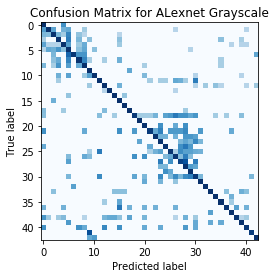

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001+cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for ALexnet Grayscale')
plt.ylabel('True label')
plt.xlabel('Predicted label')

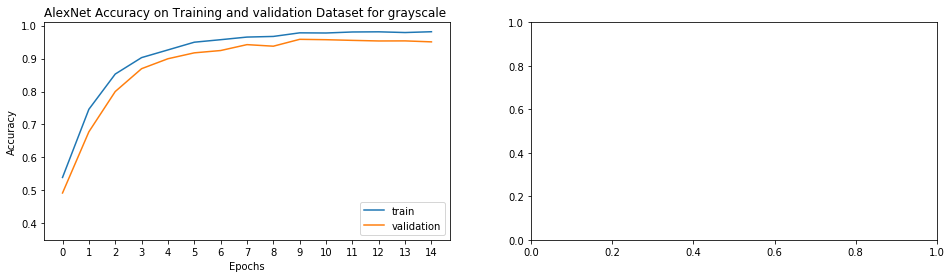

In [0]:

val_accs = np.load('/gdrive/My Drive/ML_project/AlexNet_val_accs.npy')
train_accs = np.load('/gdrive/My Drive/ML_project/AlexNet_train_accs.npy')
fig0, axes0 = plt.subplots(1, 2, figsize=(16,4))

axes0[0].plot(range(0,len(train_accs)),train_accs, label='train')
axes0[0].plot(range(0,len(val_accs)),val_accs, label='validation')
axes0[0].set_xlabel('Epochs')
axes0[0].set_ylabel('Accuracy')
axes0[0].set_xticks(range(0,len(val_accs),1))
# axes0[0].set_xlim([1,25])
axes0[0].set_ylim([0.35,1.01])
axes0[0].set_title('AlexNet Accuracy on Training and validation Dataset for grayscale ')
axes0[0].legend(loc=4)
# axes0[0].grid(True)
# axes0[1].plot(range(0,len(val_accs_BN)),val_accs_BN, label='With BN')
# axes0[1].plot(range(0,len(val_accs)),val_accs, label='Without BN')
# axes0[1].set_xlabel('Epochs')
# axes0[1].set_ylabel('Accuracy')
# axes0[1].set_xticks(range(0,len(val_accs),1))
# axes0[1].set_ylim([0.85,1])
# axes0[1].set_title('Accuracy on Validation Dataset')
# axes0[1].legend(loc=4)
# axes0[1].grid(True)

plt.show()



In [0]:
count =0
class_err = [0]*43
# buckets = [0] * 100
for i in range(12630):
  if(y_test[i] !=y_pred[i]):
    count +=1
    class_err[y_test[i]]+=1
    # print('Misclassified label no.s', i, y_pred[i])
for j in range(43):
  print(j, class_err[j])


0 19
1 31
2 20
3 52
4 40
5 45
6 29
7 37
8 87
9 1
10 23
11 63
12 12
13 2
14 2
15 1
16 1
17 20
18 51
19 0
20 19
21 18
22 6
23 25
24 12
25 55
26 23
27 28
28 9
29 4
30 31
31 1
32 0
33 6
34 1
35 8
36 6
37 3
38 26
39 1
40 9
41 15
42 6


In [0]:
count

1013